In [1]:
import numpy as np
import pandas as pd
import time
import datetime
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import svm
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn import preprocessing
import random
from bayes_opt import BayesianOptimization
sns.set()
from pprint import pprint
import json
import math

In [2]:
def get_state(data, t, n):
    d = t - n + 1
    block = data[d : t + 1] if d >= 0 else -d * [data[0]] + data[0 : t + 1]
    res = []
    for i in range(n - 1):
        res.append(block[i + 1] - block[i])
    return np.array([res])

In [3]:
df = pd.read_csv('5YRIXIC.csv')
df.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,8/05/2014,4053,4109,4040,4052,4052,2411940000
1,9/05/2014,4043,4072,4025,4072,4072,1976160000
2,12/05/2014,4093,4147,4092,4144,4144,1880020000
3,13/05/2014,4145,4155,4128,4130,4130,1923480000
4,14/05/2014,4122,4132,4094,4101,4101,1764430000


In [4]:
close = df.Close.values.tolist()
window_size = 30
skip = 5
l = len(close) - 1

In [5]:
class Deep_Evolution_Strategy:

    inputs = None

    def __init__(
        self, weights, reward_function, population_size, sigma, learning_rate
    ):
        self.weights = weights
        self.reward_function = reward_function
        self.population_size = population_size
        self.sigma = sigma
        self.learning_rate = learning_rate

    def _get_weight_from_population(self, weights, population):
        weights_population = []
        for index, i in enumerate(population):
            jittered = self.sigma * i
            weights_population.append(weights[index] + jittered)
        return weights_population

    def get_weights(self):
        return self.weights

    def train(self, epoch = 100, print_every = 1):
        lasttime = time.time()
        for i in range(epoch):
            population = []
            rewards = np.zeros(self.population_size)
            for k in range(self.population_size):
                x = []
                for w in self.weights:
                    x.append(np.random.randn(*w.shape))
                population.append(x)
            for k in range(self.population_size):
                weights_population = self._get_weight_from_population(
                    self.weights, population[k]
                )
                rewards[k] = self.reward_function(weights_population)
            rewards = (rewards - np.mean(rewards)) / np.std(rewards)
            for index, w in enumerate(self.weights):
                A = np.array([p[index] for p in population])
                self.weights[index] = (
                    w
                    + self.learning_rate
                    / (self.population_size * self.sigma)
                    * np.dot(A.T, rewards).T
                )
            if (i + 1) % print_every == 0:
                print(
                    'iter %d. reward: %f'
                    % (i + 1, self.reward_function(self.weights))
                )
        print('time taken to train:', time.time() - lasttime, 'seconds')


class Model:
    def __init__(self, input_size, layer_size, output_size):
        self.weights = [
            np.random.randn(input_size, layer_size),
            np.random.randn(layer_size, output_size),
            np.random.randn(layer_size, 1),
            np.random.randn(1, layer_size),
        ]

    def predict(self, inputs):
        feed = np.dot(inputs, self.weights[0]) + self.weights[-1]
        decision = np.dot(feed, self.weights[1])
        buy = np.dot(feed, self.weights[2])
        return decision, buy

    def get_weights(self):
        return self.weights

    def set_weights(self, weights):
        self.weights = weights

In [6]:
class Agent:
    def __init__(
        self,
        population_size,
        sigma,
        learning_rate,
        model,
        money,
        max_buy,
        max_sell,
        skip,
        window_size,
    ):
        self.window_size = window_size # means look back 20 historical data to trade
        self.skip = skip
        self.POPULATION_SIZE = population_size
        self.SIGMA = sigma
        self.LEARNING_RATE = learning_rate
        self.model = model
        self.initial_money = money
        self.max_buy = max_buy
        self.max_sell = max_sell
        self.es = Deep_Evolution_Strategy(
            self.model.get_weights(),
            self.get_reward,
            self.POPULATION_SIZE,
            self.SIGMA,
            self.LEARNING_RATE,
        )

    def act(self, sequence):
        decision, buy = self.model.predict(np.array(sequence))
        return np.argmax(decision[0]), int(buy[0])

    def get_reward(self, weights):
        initial_money = self.initial_money
        starting_money = initial_money
        self.model.weights = weights
        state = get_state(close, 0, self.window_size + 1)
        inventory = []
        quantity = 0
        for t in range(0, l, self.skip):
            action, buy = self.act(state)
            next_state = get_state(close, t + 1, self.window_size + 1)
            if action == 1 and initial_money >= close[t]:
                if buy < 0:
                    buy = 1
                if buy > self.max_buy:
                    buy_units = self.max_buy
                else:
                    buy_units = buy
                total_buy = buy_units * close[t]
                initial_money -= total_buy
                inventory.append(total_buy)
                quantity += buy_units
            elif action == 2 and len(inventory) > 0:
                if quantity > self.max_sell:
                    sell_units = self.max_sell
                else:
                    sell_units = quantity
                quantity -= sell_units
                total_sell = sell_units * close[t]
                initial_money += total_sell

            state = next_state
        return ((initial_money - starting_money) / starting_money) * 100

    def fit(self, iterations, checkpoint):
        self.es.train(iterations, print_every = checkpoint)

    def buy(self):
        initial_money = self.initial_money
        state = get_state(close, 0, self.window_size + 1)
        starting_money = initial_money
        states_sell = []
        states_buy = []
        inventory = []
        quantity = 0
        profit = 0
        loss = 0
        for t in range(0, l, self.skip):
            action, buy = self.act(state)
            next_state = get_state(close, t + 1, self.window_size + 1)
            if action == 1 and initial_money >= close[t]:
                if buy < 0:
                    buy = 1
                if buy > self.max_buy:
                    buy_units = self.max_buy
                else:
                    buy_units = buy
                total_buy = buy_units * close[t]
                initial_money -= total_buy
                inventory.append(total_buy)
                quantity += buy_units
                states_buy.append(t)
                print(
                    'day %d: buy %d units at price %f, total balance %f'
                    % (t, buy_units, total_buy, initial_money)
                )
            elif action == 2 and len(inventory) > 0:
                bought_price = inventory.pop(0)
                if quantity > self.max_sell:
                    sell_units = self.max_sell
                else:
                    sell_units = quantity
                if sell_units < 1:
                    continue
                quantity -= sell_units
                total_sell = sell_units * close[t]
                initial_money += total_sell
                states_sell.append(t)
                try:
                    invest = ((total_sell - bought_price) / bought_price) * 100
                except:
                    invest = 0
                print(
                    'day %d, sell %d units at price %f, investment %f %%, total balance %f,'
                    % (t, sell_units, total_sell, invest, initial_money)
                )
                if invest > 0:
                    profit += 1
                else:
                    loss += 1
            state = next_state

        invest = ((initial_money - starting_money) / starting_money) * 100
        ratio = (profit / (loss + profit)) * 100
        print(
            '\ntotal gained %f, total investment %f %%'
            % (initial_money - starting_money, invest)
        )
        print(
            'total wins %d , total losses %d, accuracy ratio: %f'
            % (profit , loss , ratio)
            )
        print('left in inventory: %d' % (len(inventory)))
        print(inventory)
        print('\nPredicted Buy/Sell for ' +str(len(close))+ ' ROI: ' + str(int(invest))+'%')
        plt.figure(figsize = (20, 10))
        plt.plot(close, label = 'true close', c = 'g')
        plt.plot(
            close, 'X', label = 'predict buy', markevery = states_buy, c = 'b'
        )
        plt.plot(
            close, 'o', label = 'predict sell', markevery = states_sell, c = 'r'
        )
        plt.legend()
        plt.show()

In [7]:
def best_agent(
    window_size, skip, population_size, sigma, learning_rate, size_network
):
    model = Model(window_size, size_network, 3)
    agent = Agent(
        population_size,
        sigma,
        learning_rate,
        model,
        10000,
        300,
        300,
        skip,
        window_size,
    )
    try:
        agent.fit(10, 1000)
        return agent.es.reward_function(agent.es.weights)
    except:
        return 0

In [8]:
def find_best_agent(
    window_size, skip, population_size, sigma, learning_rate, size_network
):
    global accbest
    param = {
        'window_size': int(np.around(window_size)),
        'skip': int(np.around(skip)),
        'population_size': int(np.around(population_size)),
        'sigma': max(min(sigma, 1), 0.0001),
        'learning_rate': max(min(learning_rate, 0.5), 0.000001),
        'size_network': int(np.around(size_network)),
    }
    print('\nSearch parameters %s' % (param))
    investment = best_agent(**param)
    print('stop after 100 iteration with investment %f' % (investment))
    if investment > accbest:
        costbest = investment
    return investment

In [9]:
accbest = 0.0
NN_BAYESIAN = BayesianOptimization(
    find_best_agent,
    {
        'window_size': (2, 50), # Default: 2, 50
        'skip': (1, 15), # Default: 1, 15
        'population_size': (1, 50), # Default: 1, 50
        'sigma': (0.01, 0.99),
        'learning_rate': (0.000001, 0.49), # Default: 0.000001 , 0.49
        'size_network': (10, 1000), # Default: 10, 1000
    },
)
NN_BAYESIAN.maximize(init_points = 50, n_iter = 80, acq = 'ei', xi = 0.0) # Default: init_points=30 n_iter=50

Initialization
----------------------------------------------------------------------------------------------------------------------------
 Step |   Time |      Value |   learning_rate |   population_size |     sigma |   size_network |      skip |   window_size | 

Search parameters {'window_size': 33, 'skip': 7, 'population_size': 46, 'sigma': 0.12009276950352694, 'learning_rate': 0.377395280805119, 'size_network': 611}
time taken to train: 8.93803071975708 seconds
stop after 100 iteration with investment 10491.620000
    1 | 00m08s | 10491.62000 |          0.3774 |           45.8017 |    0.1201 |       611.3683 |    6.7595 |       33.1377 | 

Search parameters {'window_size': 5, 'skip': 6, 'population_size': 5, 'sigma': 0.6264526752574345, 'learning_rate': 0.4305097308596507, 'size_network': 883}
time taken to train: 0.24994301795959473 seconds
stop after 100 iteration with investment -435.000000
    2 | 00m00s | -435.00000 |          0.4305 |            5.4442 |    0.6265 |       8

C:\Users\Bl4ckP3n9u1n\AppData\Roaming\Python\Python37\site-packages\ipykernel_launcher.py:39: RuntimeWarning: invalid value encountered in true_divide


stop after 100 iteration with investment 0.000000
   18 | 00m00s |    0.00000 |          0.1049 |           21.6778 |    0.0145 |       882.8779 |   10.5247 |       30.5199 | 

Search parameters {'window_size': 11, 'skip': 8, 'population_size': 27, 'sigma': 0.784220573381466, 'learning_rate': 0.18994933550207715, 'size_network': 976}
time taken to train: 4.5447680950164795 seconds
stop after 100 iteration with investment -197.100000
   19 | 00m04s | -197.10000 |          0.1899 |           27.0016 |    0.7842 |       975.5900 |    7.8099 |       11.4583 | 

Search parameters {'window_size': 24, 'skip': 5, 'population_size': 8, 'sigma': 0.5002623384186061, 'learning_rate': 0.4508853114540408, 'size_network': 560}
time taken to train: 2.117885112762451 seconds
stop after 100 iteration with investment 10386.380000
   20 | 00m02s | 10386.38000 |          0.4509 |            7.6653 |    0.5003 |       560.2202 |    4.9811 |       23.7989 | 

Search parameters {'window_size': 17, 'skip': 8, 

time taken to train: 0.8644304275512695 seconds
stop after 100 iteration with investment 4527.860000
   40 | 00m00s | 4527.86000 |          0.2332 |           20.9531 |    0.4767 |       137.7973 |   11.5875 |       43.9046 | 

Search parameters {'window_size': 37, 'skip': 12, 'population_size': 41, 'sigma': 0.6478221175998324, 'learning_rate': 0.3867784654413062, 'size_network': 449}
time taken to train: 5.027214527130127 seconds
stop after 100 iteration with investment 10392.680000
   41 | 00m05s | 10392.68000 |          0.3868 |           41.3482 |    0.6478 |       449.4873 |   12.1942 |       37.2690 | 

Search parameters {'window_size': 30, 'skip': 1, 'population_size': 31, 'sigma': 0.6756434597122165, 'learning_rate': 0.38634543331878324, 'size_network': 728}
time taken to train: 41.45520091056824 seconds
stop after 100 iteration with investment -65.200000
   42 | 00m41s |  -65.20000 |          0.3863 |           31.0361 |    0.6756 |       728.1824 |    1.4557 |       29.9398 |

C:\Users\Bl4ckP3n9u1n\AppData\Roaming\Python\Python37\site-packages\ipykernel_launcher.py:39: RuntimeWarning: invalid value encountered in true_divide



Search parameters {'window_size': 6, 'skip': 9, 'population_size': 17, 'sigma': 0.9108292968568122, 'learning_rate': 0.3834271599327463, 'size_network': 411}
time taken to train: 0.5324664115905762 seconds
stop after 100 iteration with investment -676.840000
   52 | 00m01s | -676.84000 |          0.3834 |           17.2206 |    0.9108 |       410.5734 |    9.0807 |        5.9216 | 

Search parameters {'window_size': 3, 'skip': 6, 'population_size': 36, 'sigma': 0.06738007480830621, 'learning_rate': 0.3769100861054153, 'size_network': 726}


C:\Users\Bl4ckP3n9u1n\AppData\Roaming\Python\Python37\site-packages\ipykernel_launcher.py:39: RuntimeWarning: invalid value encountered in true_divide


stop after 100 iteration with investment 0.000000
   53 | 00m02s |    0.00000 |          0.3769 |           35.9289 |    0.0674 |       726.3961 |    6.2617 |        2.8514 | 

Search parameters {'window_size': 13, 'skip': 7, 'population_size': 4, 'sigma': 0.8237737491770946, 'learning_rate': 0.291564632972658, 'size_network': 16}
time taken to train: 0.15352702140808105 seconds
stop after 100 iteration with investment 2281.690000
   54 | 00m01s | 2281.69000 |          0.2916 |            4.3257 |    0.8238 |        15.9766 |    6.9133 |       13.3047 | 

Search parameters {'window_size': 26, 'skip': 13, 'population_size': 25, 'sigma': 0.8501727078345896, 'learning_rate': 0.39026515822843966, 'size_network': 715}
time taken to train: 2.721390724182129 seconds
stop after 100 iteration with investment 1459.720000
   55 | 00m04s | 1459.72000 |          0.3903 |           25.3091 |    0.8502 |       714.9267 |   12.9296 |       25.5954 | 

Search parameters {'window_size': 36, 'skip': 8, '


Search parameters {'window_size': 39, 'skip': 13, 'population_size': 37, 'sigma': 0.757731083813604, 'learning_rate': 0.39493985792265546, 'size_network': 507}
time taken to train: 4.441093921661377 seconds
stop after 100 iteration with investment 3109.720000
   75 | 00m06s | 3109.72000 |          0.3949 |           37.4136 |    0.7577 |       507.4427 |   12.8931 |       38.6438 | 

Search parameters {'window_size': 15, 'skip': 1, 'population_size': 49, 'sigma': 0.1915591712435069, 'learning_rate': 0.05186833949671413, 'size_network': 497}
time taken to train: 15.964420557022095 seconds
stop after 100 iteration with investment 9300.400000
   76 | 00m17s | 9300.40000 |          0.0519 |           49.2254 |    0.1916 |       497.2266 |    1.1460 |       15.1417 | 

Search parameters {'window_size': 11, 'skip': 6, 'population_size': 12, 'sigma': 0.5042188905153049, 'learning_rate': 0.3243386771913798, 'size_network': 309}
time taken to train: 0.585756778717041 seconds
stop after 100 ite


Search parameters {'window_size': 25, 'skip': 11, 'population_size': 44, 'sigma': 0.038838446617203544, 'learning_rate': 0.09303018442667849, 'size_network': 76}
time taken to train: 1.2875065803527832 seconds
stop after 100 iteration with investment 10760.630000
   96 | 00m03s | 10760.63000 |          0.0930 |           44.3431 |    0.0388 |        75.9054 |   10.9956 |       25.2429 | 

Search parameters {'window_size': 36, 'skip': 12, 'population_size': 1, 'sigma': 0.5849210784862403, 'learning_rate': 0.15953506852387747, 'size_network': 372}
stop after 100 iteration with investment 0.000000
   97 | 00m02s |    0.00000 |          0.1595 |            1.2878 |    0.5849 |       371.8714 |   11.9998 |       36.3552 | 


C:\Users\Bl4ckP3n9u1n\AppData\Roaming\Python\Python37\site-packages\ipykernel_launcher.py:39: RuntimeWarning: invalid value encountered in true_divide



Search parameters {'window_size': 40, 'skip': 13, 'population_size': 20, 'sigma': 0.5238004069072655, 'learning_rate': 0.40713343984086325, 'size_network': 898}
time taken to train: 2.4675350189208984 seconds
stop after 100 iteration with investment 7809.720000
   98 | 00m04s | 7809.72000 |          0.4071 |           19.9783 |    0.5238 |       898.0875 |   12.5765 |       39.8539 | 

Search parameters {'window_size': 32, 'skip': 13, 'population_size': 13, 'sigma': 0.29016628710869474, 'learning_rate': 0.4583972393113396, 'size_network': 24}
time taken to train: 0.320941686630249 seconds
stop after 100 iteration with investment 8194.670000
   99 | 00m02s | 8194.67000 |          0.4584 |           12.6070 |    0.2902 |        23.5587 |   12.9013 |       32.4919 | 

Search parameters {'window_size': 31, 'skip': 4, 'population_size': 13, 'sigma': 0.7233920813548899, 'learning_rate': 0.15038939853706274, 'size_network': 552}
time taken to train: 4.563291072845459 seconds
stop after 100 i

C:\Users\Bl4ckP3n9u1n\AppData\Roaming\Python\Python37\site-packages\ipykernel_launcher.py:39: RuntimeWarning: invalid value encountered in true_divide



Search parameters {'window_size': 7, 'skip': 9, 'population_size': 2, 'sigma': 0.6903966683288902, 'learning_rate': 0.1224512467294913, 'size_network': 385}
time taken to train: 0.05337071418762207 seconds
stop after 100 iteration with investment -179.130000
  102 | 00m02s | -179.13000 |          0.1225 |            2.0411 |    0.6904 |       385.3817 |    9.2548 |        7.4524 | 

Search parameters {'window_size': 8, 'skip': 1, 'population_size': 11, 'sigma': 0.5420301276632313, 'learning_rate': 0.4520020389256746, 'size_network': 860}
time taken to train: 3.791656970977783 seconds
stop after 100 iteration with investment -406.370000
  103 | 00m06s | -406.37000 |          0.4520 |           10.9256 |    0.5420 |       859.5127 |    1.3243 |        7.8691 | 

Search parameters {'window_size': 20, 'skip': 7, 'population_size': 45, 'sigma': 0.16566057701439968, 'learning_rate': 0.13134832189358853, 'size_network': 673}
time taken to train: 8.433716297149658 seconds
stop after 100 itera

C:\Users\Bl4ckP3n9u1n\AppData\Roaming\Python\Python37\site-packages\ipykernel_launcher.py:39: RuntimeWarning: invalid value encountered in true_divide



Search parameters {'window_size': 5, 'skip': 7, 'population_size': 49, 'sigma': 0.16231915537538127, 'learning_rate': 0.4807149189483596, 'size_network': 609}
time taken to train: 1.921320915222168 seconds
stop after 100 iteration with investment 4665.630000
  108 | 00m04s | 4665.63000 |          0.4807 |           48.5831 |    0.1623 |       609.2851 |    6.9828 |        4.8495 | 

Search parameters {'window_size': 16, 'skip': 12, 'population_size': 6, 'sigma': 0.7632938429002872, 'learning_rate': 0.3466974769143941, 'size_network': 976}
time taken to train: 0.6949713230133057 seconds
stop after 100 iteration with investment -305.850000
  109 | 00m03s | -305.85000 |          0.3467 |            5.7178 |    0.7633 |       976.3505 |   11.5488 |       16.4165 | 

Search parameters {'window_size': 40, 'skip': 3, 'population_size': 31, 'sigma': 0.7248348212268712, 'learning_rate': 0.3710508196684065, 'size_network': 428}
time taken to train: 13.86202359199524 seconds
stop after 100 itera

C:\Users\Bl4ckP3n9u1n\AppData\Roaming\Python\Python37\site-packages\ipykernel_launcher.py:39: RuntimeWarning: invalid value encountered in true_divide


stop after 100 iteration with investment 0.000000
  115 | 00m04s |    0.00000 |          0.4710 |           13.1493 |    0.0707 |       463.8794 |    1.9010 |        5.0164 | 

Search parameters {'window_size': 19, 'skip': 9, 'population_size': 12, 'sigma': 0.9509505857913646, 'learning_rate': 0.2865985872124564, 'size_network': 645}
time taken to train: 1.9035975933074951 seconds
stop after 100 iteration with investment 6151.100000
  116 | 00m04s | 6151.10000 |          0.2866 |           12.4652 |    0.9510 |       644.7197 |    8.7878 |       18.9348 | 

Search parameters {'window_size': 2, 'skip': 3, 'population_size': 50, 'sigma': 0.6677510573053888, 'learning_rate': 0.027381821480481846, 'size_network': 142}
time taken to train: 4.533704519271851 seconds
stop after 100 iteration with investment -196.380000
  117 | 00m07s | -196.38000 |          0.0274 |           49.7552 |    0.6678 |       142.0416 |    2.8398 |        2.2006 | 

Search parameters {'window_size': 17, 'skip': 6, 

In [10]:
print('Best AGENT accuracy value: %f' % NN_BAYESIAN.res['max']['max_val'])
print('Best AGENT parameters: ', NN_BAYESIAN.res['max']['max_params'])

Best AGENT accuracy value: 18634.430000
Best AGENT parameters:  {'window_size': 35.50015494870006, 'skip': 9.12023375274474, 'population_size': 44.88567751983797, 'sigma': 0.2589030893009012, 'learning_rate': 0.3666254651745698, 'size_network': 302.64483562064936}


In [11]:
bayes_res = str(NN_BAYESIAN.res['max']['max_params'])
bayes_res = json.loads(bayes_res.replace("'", "\""))
bayes_res['window_size'] = int(round(bayes_res['window_size']))
bayes_res['skip'] = int(round(bayes_res['skip']))
bayes_res['population_size'] = int(round(bayes_res['population_size']))
bayes_res['size_network'] = int(round(bayes_res['size_network']))
pprint(bayes_res)

{'learning_rate': 0.3666254651745698,
 'population_size': 45,
 'sigma': 0.2589030893009012,
 'size_network': 303,
 'skip': 9,
 'window_size': 36}


iter 100. reward: 22593.200000
iter 200. reward: 23459.500000
iter 300. reward: 23468.970000
time taken to train: 212.86628007888794 seconds
day 0: buy 300 units at price 1215600.000000, total balance -1205600.000000
day 81, sell 300 units at price 1371900.000000, investment 12.857848 %, total balance 166300.000000,
day 99: buy 1 units at price 4506.000000, total balance 161794.000000
day 108: buy 300 units at price 1282800.000000, total balance -1121006.000000
day 135, sell 300 units at price 1410600.000000, investment 31204.926764 %, total balance 289594.000000,
day 144: buy 1 units at price 4756.000000, total balance 284838.000000
day 153: buy 300 units at price 1381500.000000, total balance -1096662.000000
day 162, sell 300 units at price 1442100.000000, investment 12.418148 %, total balance 345438.000000,
day 171: buy 300 units at price 1399500.000000, total balance -1054062.000000
day 261, sell 300 units at price 1527300.000000, investment 32013.120269 %, total balance 473238.000

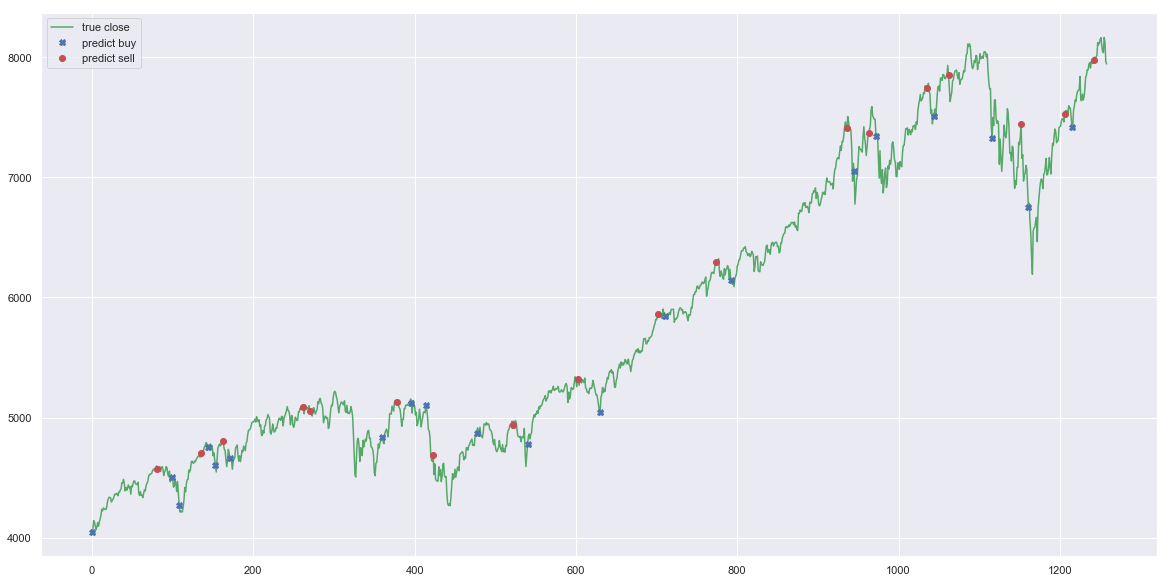

In [12]:
model = Model(bayes_res['window_size'], bayes_res['size_network'], 3)
agent = Agent(
    bayes_res['population_size'], bayes_res['sigma'], bayes_res['learning_rate'], model, 10000, 300, 300, bayes_res['skip'], bayes_res['window_size']
)
agent.fit(bayes_res['size_network'], 100)
agent.buy()

In [13]:
forecast_col = 'Close'
df.fillna(-99999, inplace=True)

forecast_out = int(math.ceil(0.01*len(df)))
print(forecast_out)

df['label'] = df[forecast_col].shift(-forecast_out)
df.dropna(inplace=True) # may not need this

x = np.array(df.drop(['label'],1))
y = np.array(df['label'])
X = preprocessing.scale(X)
x = X[:-forecast_out]
X_lately = X [-forecast_out:]

df.dropna(inplace=True)
y = np.array(df['label'])
y = np.array(df['label'])

X_train, X_test, y_train, y_test, = cross_validation.train_test_split(X, y, test_size=0.2) # 20% of df to train

clf=svm.SVR() # This can be changed if the model is not using this E.g. LinearRegression
clf.fit(X_train, y_train)
accuracy = clf.score(X_test, y_test) # https://scikit-learn.org/stable/modules/cross_validation.html
forecast_set = clf.predict(X_lately)
print('forecast_set, accuracy, forecast_out')
df.['Forecast'] = np.nan

last_date = df.iloc[-1].name
last_unix = last.date.timestamp()
one_day = 86000 # Seconds in a day, this is based on daily data
next_day = last_unix + one_day

13


NameError: name 'cross_validation' is not defined